**Upload Datasets**

In [1]:
# -------------------------------------------------
# 1. Upload train.txt, dev.txt, test.txt
# -------------------------------------------------
from google.colab import files
uploaded = files.upload()   # <-- select the three .txt files

Saving dev.txt to dev.txt
Saving test.txt to test.txt
Saving train.txt to train.txt


**Imports & Helper**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

**Data loading (DO NOT change)**

In [3]:
def load_pubmed_rct_file(filepath):
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line: continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})

# ------------------------------------------------------------------
train_df = load_pubmed_rct_file('train.txt')
dev_df   = load_pubmed_rct_file('dev.txt')
test_df  = load_pubmed_rct_file('test.txt')
# ------------------------------------------------------------------

print(f"Train samples: {len(train_df)}")
print(f"Dev   samples: {len(dev_df)}")
print(f"Test  samples: {len(test_df)}")

X_train, y_train = train_df['sentence'], train_df['label']
X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
X_test,  y_test  = test_df['sentence'],  test_df['label']

target_names = sorted(y_train.unique())
print(f"Classes: {target_names}")

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


**Class Definition**

In [9]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # ---------- log prior ----------
            # Use shape[0] to get the number of rows in the sparse matrix and numpy array
            self.class_priors[c] = np.log(X_c.shape[0] / y_array.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # ---------- Laplace smoothing ----------
            numerator   = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                nz_idx = x_i.indices
                nz_dat = x_i.data
                log_prob += np.sum(nz_dat * log_likelihoods[nz_idx])
                scores[c] = log_prob

            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)

**CountVectorizer + training**

In [10]:
# ---------- CountVectorizer ----------
count_vectorizer = CountVectorizer(
    lowercase=True,
    strip_accents='unicode',
    stop_words='english',
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=5                 # ignore very rare words
)

print("Fitting CountVectorizer ...")
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts  = count_vectorizer.transform(X_test)
print(f"Vocabulary size: {X_train_counts.shape[1]}")

# ---------- Custom NB ----------
nb_model = NaiveBayesClassifier(alpha=1.0)
print("Training custom NB ...")
nb_model.fit(X_train_counts, y_train)
print("Training complete.")

Fitting CountVectorizer ...
Vocabulary size: 86557
Training custom NB ...
Training complete.


**Test-set evaluation (Part A)**


=== Part A – Test Set Evaluation (Custom Count-Based NB) ===
Accuracy : 0.7483
Macro F1 : 0.6809
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      3621
 CONCLUSIONS       0.61      0.70      0.66      4571
     METHODS       0.83      0.85      0.84      9897
   OBJECTIVE       0.53      0.51      0.52      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.68      0.69      0.68     30135
weighted avg       0.76      0.75      0.75     30135



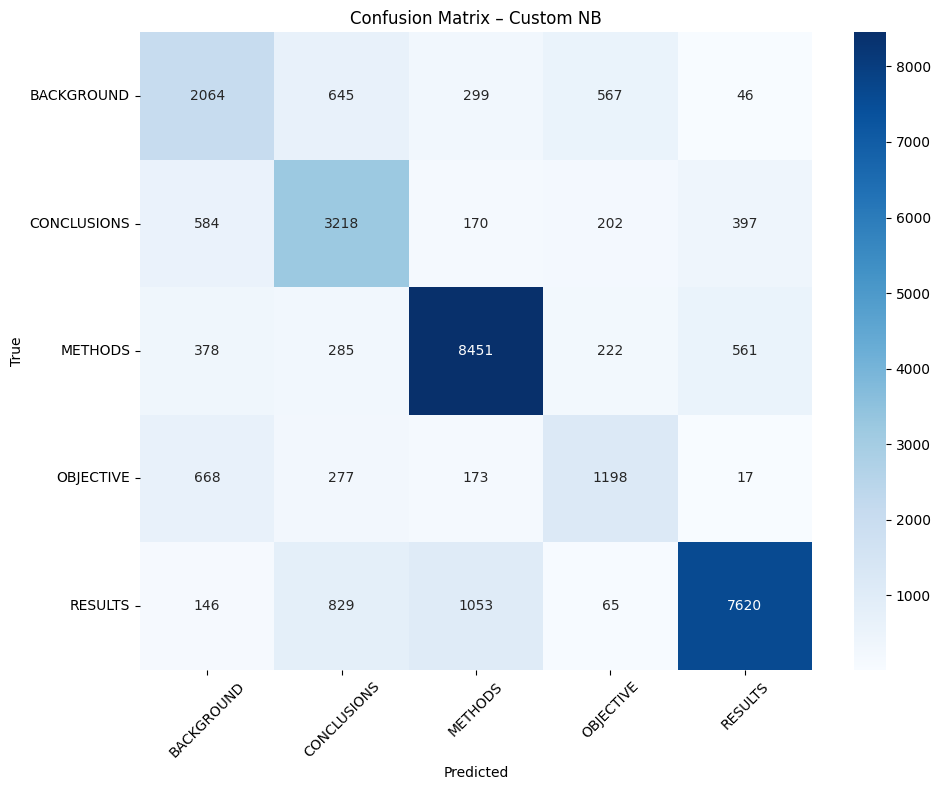

In [11]:
print("\n=== Part A – Test Set Evaluation (Custom Count-Based NB) ===")
y_test_pred = nb_model.predict(X_test_counts)

acc = accuracy_score(y_test, y_test_pred)
f1  = f1_score(y_test, y_test_pred, average='macro')
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1:.4f}")
print(classification_report(y_test, y_test_pred, target_names=target_names))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix – Custom NB')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Part B – Sklearn MultinomialNB + GridSearch**

**Pipeline & initial fit**

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('nb',    MultinomialNB())
])

print("Training initial pipeline ...")
pipeline.fit(X_train, y_train)
print("Training complete.")

Training initial pipeline ...
Training complete.


**Test-set evaluation of initial model**

In [13]:
print("\n=== Initial Sklearn Model – Test Set ===")
y_init_pred = pipeline.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_init_pred):.4f}")
print(f"Macro F1 : {f1_score(y_test, y_init_pred, average='macro'):.4f}")


=== Initial Sklearn Model – Test Set ===
Accuracy : 0.6996
Macro F1 : 0.5555


**GridSearchCV**

In [14]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearch on dev set ...")
grid.fit(X_dev, y_dev)
print("GridSearch finished.")
print("Best params :", grid.best_params_)
print("Best CV F1  :", grid.best_score_)

Running GridSearch on dev set ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearch finished.
Best params : {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best CV F1  : 0.5924853482093159


**Part C – Bayes Optimal Classifier (soft-voting ensemble)**

**SRN-based sampling**

In [15]:
BASE_SAMPLE_SIZE = 10000
FULL_SRN = input("Enter your full SRN (e.g. PES1UG22CS345): ").strip()

try:
    srn_value = int(FULL_SRN[-3:])
except Exception:
    print("Invalid SRN → using 0")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
effective = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train.iloc[:effective]
y_train_sampled = y_train.iloc[:effective]

print(f"SRN suffix      : {srn_value}")
print(f"Sample size used: {effective}")

Enter your full SRN (e.g. PES1UG22CS345): PES2UG24CS817
SRN suffix      : 817
Sample size used: 10817


**Define the 5 base pipelines (unchanged)**

In [16]:
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1,1),
    'min_df': 5
}

h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf',   MultinomialNB(alpha=1.0, fit_prior=False))])

h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf',   LogisticRegression(solver='liblinear',
                                               multi_class='auto',
                                               max_iter=1000,
                                               random_state=42))])

h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf',   CalibratedClassifierCV(
                                RandomForestClassifier(n_estimators=50,
                                                       max_depth=10,
                                                       random_state=42,
                                                       n_jobs=-1),
                                cv=3, method='isotonic'))])

h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf',   CalibratedClassifierCV(
                                DecisionTreeClassifier(max_depth=10,
                                                       random_state=42),
                                cv=3, method='isotonic'))])

h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                   ('clf',  CalibratedClassifierCV(
                                KNeighborsClassifier(n_neighbors=5,
                                                     n_jobs=-1),
                                cv=3, method='isotonic'))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hyp_names   = ['NB','LR','RF','DT','KNN']

**Posterior weight calculation**

In [17]:
# split sampled data into sub-train / validation
X_sub, X_val, y_sub, y_val = train_test_split(
    X_train_sampled, y_train_sampled,
    test_size=0.2, random_state=42, stratify=y_train_sampled)

log_liks = []
for name, hyp in zip(hyp_names, hypotheses):
    print(f"Training {name} for weight calculation ...")
    hyp.fit(X_sub, y_sub)
    proba = hyp.predict_proba(X_val)
    ll = -log_loss(y_val, proba)      # higher = better
    log_liks.append(ll)
    print(f"  → log-likelihood = {ll:.4f}")

# softmax to posterior weights
log_liks = np.array(log_liks)
posterior_weights = np.exp(log_liks - log_liks.max())
posterior_weights /= posterior_weights.sum()
print("Posterior weights :", np.round(posterior_weights,4))

Training NB for weight calculation ...
  → log-likelihood = -0.9798
Training LR for weight calculation ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  → log-likelihood = -0.9053
Training RF for weight calculation ...
  → log-likelihood = -0.9918
Training DT for weight calculation ...
  → log-likelihood = -1.2690
Training KNN for weight calculation ...
  → log-likelihood = -1.4510
Posterior weights : [0.2253 0.2427 0.2226 0.1687 0.1406]


**Refit on full sampled data**

In [18]:
print("\nRefitting all models on *full* sampled data ...")
for name, hyp in zip(hyp_names, hypotheses):
    hyp.fit(X_train_sampled, y_train_sampled)


Refitting all models on *full* sampled data ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Soft-voting BOC**

In [19]:
estimators = list(zip(hyp_names, hypotheses))

boc = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("Fitting BOC (soft voting) ...")
boc.fit(X_train_sampled, y_train_sampled)
print("BOC fit complete.")

Fitting BOC (soft voting) ...
BOC fit complete.


**Final BOC evaluation**


=== Final BOC Evaluation on full test set ===
Accuracy : 0.6973
Macro F1 : 0.5959

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.31      0.41      3621
 CONCLUSIONS       0.59      0.52      0.56      4571
     METHODS       0.68      0.89      0.77      9897
   OBJECTIVE       0.69      0.33      0.45      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.67      0.57      0.60     30135
weighted avg       0.69      0.70      0.68     30135



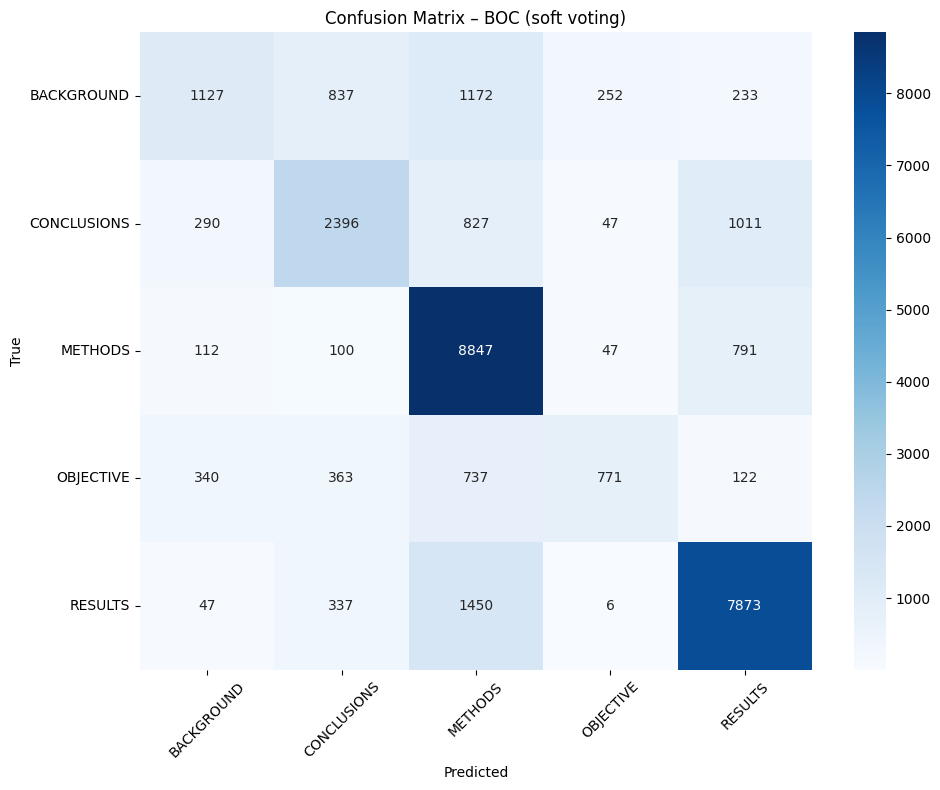

In [20]:
print("\n=== Final BOC Evaluation on full test set ===")
y_boc_pred = boc.predict(X_test)

acc = accuracy_score(y_test, y_boc_pred)
f1  = f1_score(y_test, y_boc_pred, average='macro')
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_boc_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_boc_pred, labels=target_names)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix – BOC (soft voting)')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()